# CheXpert Classification

### Dependencies

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#import torch
#import torchvision
#import torchsummary
#from torch.autograd import Variable
#import onnx
#from onnx_tf.backend import prepare
#from pytorch2keras import pytorch_to_keras

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Variables

In [3]:
epochs = 10
batch_size = 32
learning_rate = 0.0001
max_data = 50000

dataset_dir = "D:/Arthur/TIPE/data"
img_size = (224, 224, 1)
big_batch_size = 320

# Classes (only 5 of them)
classes = ["Cardiomegaly", 
           "Edema",
           "Consolidation", 
           "Atelectasis", 
           "Pleural Effusion"]

# Preparation

## Data Fetching

### 'deprecated' - Load the entire dataset

### 'done' - Preprocessing data

### Create DataGenerator

#### 'deprecated' - Directly loading images

#### Loading *.npz files

In [4]:
# Variante pour les fichiers npz

class DataGenerator(tf.keras.utils.Sequence):
    """
    Load data from pre-processed *.npz files (normalized, etc.)
    """
    
    def __init__(self, batch_size, dataset_directory):
        self.batch_size = batch_size
        self.directory = dataset_directory
        self.list_IDs = os.listdir(self.directory)
   
    def __len__(self):
        return min(len(self.list_IDs) * big_batch_size, max_data) // self.batch_size

    def __getitem__(self, index):
        
        big_batch = (index * self.batch_size) // big_batch_size
        
        np_file = np.load(self.directory+"/batch_{}.npz".format(big_batch))
        
        return np_file["images"][(index*self.batch_size)%big_batch_size : ((index*self.batch_size)%big_batch_size)+self.batch_size], \
               np_file["targets"][(index*self.batch_size)%big_batch_size : ((index*self.batch_size)%big_batch_size)+self.batch_size]
        
TrainingGenerator = DataGenerator(batch_size=batch_size, dataset_directory=dataset_dir+"/NPZ/train")
ValidationGenerator = DataGenerator(batch_size=batch_size, dataset_directory=dataset_dir+"/NPZ/valid")

## Model

#### Classification Head

In [5]:
class Classification_Head(tf.keras.Model):
    
    def __init__(self):
        super(Classification_Head, self).__init__()
        
        self.list_layers = [
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(len(classes), activation='sigmoid')
        ]
        
    def call(self, x):
        
        for layer in self.list_layers :
            x = layer(x)
            
        return x   

#### 'done' - Pretrained Alexnet

#### AlexNet

#### VGG16

### Compile functions

In [6]:
#learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=1000, decay_rate=0.96, staircase=True)
def compiler(model, lr) :
    
    global loss_object
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    global optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # For graph mode
    global train_loss
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    global valid_loss
    valid_loss = tf.keras.metrics.Mean(name='valid_loss')
    global train_accuracy
    train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
    global valid_accuracy
    valid_accuracy = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')

    model.compile(
            loss=loss_object,
            optimizer=optimizer,
            metrics=["binary_accuracy"])
    
    a = model(np.random.random(img_size))

## Training

### Training functions

#### Step functions

In [7]:
#@tf.function
def train_step(images, targets):

    train_vars = model.trainable_variables
    accum_gradient = [tf.zeros_like(var) for var in train_vars]
  
    for image, target in zip(images, targets) :
        
        with tf.GradientTape() as tape:
            prediction = model(image)
            target.shape = prediction.shape
            loss = loss_object(target, prediction)
        
        train_loss(loss)
        train_accuracy(target, prediction) 

        gradients = tape.gradient(loss, train_vars)
        accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
    
    accum_gradient = [grad/len(images) for grad in accum_gradient]
    
    optimizer.apply_gradients(zip(accum_gradient, model.trainable_variables))

#@tf.function
def valid_step(images, targets):
    
    predictions = model(images)
    loss = loss_object(targets, predictions)
    
    valid_loss(loss)
    valid_accuracy(targets, predictions)

#### Boucle

In [8]:
def train(model):

    b = 0 # Permet de tracker où on en est dans les batchs
    history = {'accuracy':[], 'loss':[], 'val_accuracy':[], 'val_loss':[]}
    for epoch in range(epochs):

        # TRAINING
        for images, targets in TrainingGenerator:

            train_step(images, targets)

            template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
            print(template.format(b, len(TrainingGenerator), train_loss.result(), train_accuracy.result()*100), end="")

            b += 1

        # VALIDATION
        for images, targets in ValidationGenerator:
            valid_step(images, targets)

        template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
        print(template.format(
            epoch+1,
            valid_loss.result(), 
            valid_accuracy.result()*100)
        )
        
        # On stocke les accumulateurs dans l'history
        history['accuracy'].append(train_accuracy.result())
        history['loss'].append(train_loss.result())
        history['val_accuracy'].append(valid_accuracy.result())
        history['val_loss'].append(valid_loss.result())
        
        # On reset les accumulateurs
        valid_loss.reset_states()
        valid_accuracy.reset_states()
        train_accuracy.reset_states()
        train_loss.reset_states()
        b = 0
        print("")
    
    return history

### Post-training functions

#### save_training

In [9]:
def save_training(history) :

    os.chdir(dataset_dir+"/training_sessions")

    # Create a folder for the training session
    i=0
    error = True
    while error:
        try:
            fd = "{}_{}k_{}-epochs_{}".format(model.name, str(max_data)[:-3], str(epochs), str(i))
            os.mkdir("{}".format(fd))
        except FileExistsError:
            i+=1
        else:
            error=False

    os.chdir(dataset_dir+"/training_sessions/{}".format(fd))

    # Report file
    with open("training_report.txt", "w") as f:
        f.write("TRAINING REPORT :\n\n")
        f.write("epochs = " + str(epochs))
        f.write("\nbatch_size = " + str(batch_size))
        f.write("\nlearning_rate = " + str(learning_rate))
        f.write("\nmax_data = " + str(max_data))
        f.write("\n")
        f.write("\nSummary :\n")
        model.summary(print_fn=lambda x : f.write("\n" + x))

    # Retrieve curves
    loss_curve = history["loss"]
    acc_curve = history["binary_accuracy"]
    loss_val_curve = history["val_loss"]
    acc_val_curve = history["val_binary_accuracy"]

    # Loss fig
    plt.plot(loss_curve, "r", label="Train")
    plt.plot(loss_val_curve, "g", label="Validation")
    plt.legend(loc='upper left')
    plt.title("Loss")
    plt.savefig("loss.png")
    plt.clf()

    # Accuracy fig
    plt.plot(acc_curve, "r", label="Train")
    plt.plot(acc_val_curve, "g", label="Validation")
    plt.legend(loc='upper left')
    plt.title("Accuracy")
    plt.savefig("accuracy.png")
    plt.clf()

    # Save the model
    model.save("model")

    print("# Model Saved ! #")

#### visualize_training

In [10]:
def visualize_training(history) :
    
    # Retrieve curves
    loss_curve = history["loss"]
    acc_curve = history["binary_accuracy"]

    loss_val_curve = history["val_loss"]
    acc_val_curve = history["val_binary_accuracy"]

    ### Plot the fig ###

    # Loss
    plt.plot(loss_curve, "r", label="Train")
    plt.plot(loss_val_curve, "g", label="Validation")
    plt.legend(loc='upper left')
    plt.title("Loss")

    plt.show()

    # Accuracy
    plt.plot(acc_curve, "r", label="Train")
    plt.plot(acc_val_curve, "g", label="Validation")
    plt.legend(loc='upper left')
    plt.title("Accuracy")

    plt.show()

# LAB

In [11]:
# Alexnet
pretrained_extractor = tf.keras.models.load_model("pretrained_model/alexnet_pretrained.h5")

# VGG16
#pretrained_extractor = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

classification_head = Classification_Head()

In [12]:
class model(tf.keras.Model):
    
    def __init__(self, name):
        super(model, self).__init__(name=name)
        
        self.base = pretrained_extractor
        self.base.trainable = False
        
        self.classification = classification_head
        
        self.base.trainable = False
        
    def call(self, x):
        
        x = tf.image.grayscale_to_rgb(x)
        x = tf.reshape(x, shape=(-1,3,224,224))
        x = self.base(x)
        x = self.classification(x)
            
        return x

In [13]:
model = model(name="AlexNet")
compiler(model, learning_rate)

Epoch 1/10
1562/1562 [==============================] - 312s 199ms/step - loss: 0.4605 - binary_accuracy: 0.8001 - val_loss: 0.5445 - val_binary_accuracy: 0.7307
Epoch 2/10
1562/1562 [==============================] - 294s 188ms/step - loss: 0.4345 - binary_accuracy: 0.8092 - val_loss: 0.5499 - val_binary_accuracy: 0.7277
Epoch 3/10
1562/1562 [==============================] - 287s 184ms/step - loss: 0.4270 - binary_accuracy: 0.8118 - val_loss: 0.5433 - val_binary_accuracy: 0.7228
Epoch 4/10
1562/1562 [==============================] - 288s 184ms/step - loss: 0.4225 - binary_accuracy: 0.8143 - val_loss: 0.5448 - val_binary_accuracy: 0.7297
Epoch 5/10
1562/1562 [==============================] - 306s 196ms/step - loss: 0.4183 - binary_accuracy: 0.8162 - val_loss: 0.5396 - val_binary_accuracy: 0.7297
Epoch 6/10
1562/1562 [==============================] - 282s 181ms/step - loss: 0.4144 - binary_accuracy: 0.8179 - val_loss: 0.5395 - val_binary_accuracy: 0.7327
Epoch 7/10
1562/1562 [======

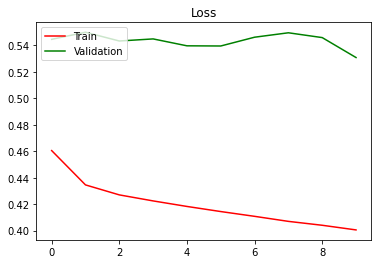

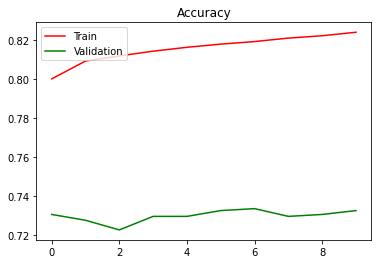

In [14]:
history = model.fit(TrainingGenerator, batch_size=batch_size, epochs=epochs, validation_data=ValidationGenerator)

save_training(history.history)
visualize_training(history.history)

### Loading previsous models

In [16]:
#loaded_model = tf.keras.models.load_model("*.h5")